# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
p = 3   # spline degree 
n_el = (30,15)   # number of elements in y/x direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

In [3]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.quarter_annulus().rotate_2d(3*pi/2),
    geometry.quarter_annulus().rotate_2d(pi),
    geometry.quarter_annulus().rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP_u = assemble.Multipatch(patches_u, automatch=True)

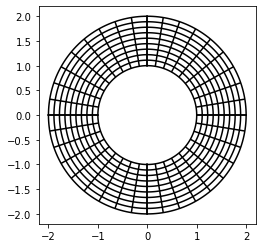

In [4]:
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [5]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [6]:
# source term f 
def f(x, y): return (0.0, 0.0)
def f_zero(x, y): return (0.0)

#Neumann BC
def gN(x, y): return (4.5e-4, -4.5e-4) 

neu_data = [
    (3,'right',gN) 
]

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )

In [7]:
# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)
# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero )
])

In [8]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch
def get_defplot(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
   
    # restrict solution to each individual patch
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    
    # grid variables
    ref = 10
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    
    figsize(10,10)
    fig, ax = plt.subplots()
    
     # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-4)
        
    colorbar();
    axis('equal')


In [9]:
# Compute solution of nonlinear elasticity problem

In [10]:
#split the solution into its components (displacement in x- and y- direction)
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [11]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam* assemble.assemble('div(dis)*div(v) * dx+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v)*dx + inner(div(dis)*grad(dis), grad(v))*dx + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    A_lin_lam = Lam* assemble.assemble('(inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) ) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A
    
    A_lin_mu = 2*Mu * assemble.assemble('(inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A
    
    return A_lin_lam + A_lin_mu


def J_u(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    f4 = assemble.assemble('sin(x[0]) * cos(x[1]) * v * dx', kvs_ux, geo=geo_ux)
    print('Integral:', f4.sum())
    
     
    f5 = assemble.assemble('v * ds', kvs_ux, geo=geo_ux, boundary='left')
    # r=1 at inner mantle, one quarter of the full circle
    print('f5=', np.allclose(f5.sum(), (2 * 1 * np.pi) / 4))
    
    
    j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))* tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis)) *dx'
                             , kvs_ux, bfuns=[('v',1)], geo=geo_ux, dis=dis)
    j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis)))  *dx'
                                    , kvs_ux, bfuns=[('v',1)], geo=geo_ux, dis=dis)
    j_u = (j_lam + j_mu).ravel() 
    return j_u.sum()  # sum of vector (=inner product with const v=1)



In [12]:
# assemble matrix A and rhs b for nonlinear elasticity problem
def ass_nonlinsystem(u):
    first = True
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]
        
        #dis = get_components(X.T @ u, kvs_ux)

        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form

        # The patch-local right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs

        # The patch-local Neumann boundary data
        for item in neu_data:
            if item[0]==p:
                N_e   = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_e[c,i,0]

        if first:
            A = X @ A_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p 
    
    return A, b

In [139]:
# elasticity problem
#linear problem = linearized problem (for development point x_0=(0...0) )
def grad_J(x): #nonlin function (rhs) # u
    # a(u,v)-l(v)
    u_p = x
    first = True
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        
        b_p= apply_nl(u_p, kvs_ux, geo_ux, X) #non-linear form a(u,v)
        b0_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() # rhs for nbc
        
        for item in neu_data:
            if item[0]==p:
                N_e  = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
                #print('N=',N_e)
                #print(shape(N_e))
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b0_p[bdofs[i]+offset] += N_e[c,i,0]
        #print(b0_p)            
        if first:
            b1 = X @ (b_p- b0_p)#"Au-b"
            first = False
        else:
            b1 += X @ (b_p- b0_p) 
            
    return b1


def J(x): #energy functional
    u_p = x
    j_N = 0
    j = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))* tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis)) *v *dx'
                             , kvs_ux, bfuns=[('v',1)], geo=geo_ux, dis=dis)
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis))) *v *dx'
                                    , kvs_ux, bfuns=[('v',1)], geo=geo_ux, dis=dis)
        j_p = (j_lam + j_mu).sum() 
        #print('j_p=', j_p)
        

        
        for item in neu_data:
            if item[0]==p:
                N_e  = assemble.assemble('inner(g , dis)*v *ds', kvs_ux, bfuns=[('v',1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis)
                #print('N=',N_e)
                j_N += N_e.sum()
        #print('j_N=', j_N)

        j += (j_p- j_N)

    #print('J_u=', j)
    return j


In [140]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.1
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha=1
    phi_min = -1.e2
    eps0 = 1.e-6
    
    while True:
        if alpha > 1: # alpha too big # alpha in(0,1)!
            print('alpha >1')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            #print('a=', alpha)
            phi_hat= phi(alpha)
            if phi_hat < phi_min: # function unbounded to the bottom
                print('function unbounded to the bottom')
                #print('phi_hat < phi_min', phi_hat)
                return alpha 
                #break
                
            if phi_hat > phi(0) + mu1*alpha*derphi(0) + eps0: #alpha too big # +eps0, otherwise alpha gets too small!
                print('phi_hat=', phi_hat)
                print('cond1: ', phi(0) + mu1*alpha*derphi(0))
                print('alpha too big')
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
                print('delta=', delta)
                # interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                print('alpha_int=', alpha)
            
            else: # alpha too small & not too big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # alpha too small
                    print('alpha too small')
                    if alphainf: # true, alpha_R =inf
                        print(' alpha_R = inf')
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        print('alpha_R < inf')
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    # update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha
                    #break


                
                        

In [141]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]
#print(dd)

#initial value
u= np.zeros(dd)
#print(u)


### first iteration ###
A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
#print(ass_nonlinsystem(u)[1])

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

u_d= solvers.make_solver(LS.A).dot(LS.b)

u_d = LS.complete(u_d)
#print(u_d)

x1= J(u)
print(x1)
x2= grad_J(u)
print(x2)
alpha= Wolfe_LineSearch(J, grad_J, u, u_d)

print('alpha=', alpha)

u += alpha*u_d
print(u)


solution = [LS.restrict(u)]
#print(solution[-1])

# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))

residual =  0.0003590464092893082
0.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 1.0647827e-05]
alpha= 1
[ 0.13659506  0.13665481  0.13689992 ... -0.43936726 -0.41710794
 -0.40360778]


In [142]:
### first iteration ###
A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

u_d= solvers.make_solver(LS.A).dot(LS.b)

u_d = LS.complete(u_d)


#x1= J(u)
#print(x1)
#x2= grad_J(u)
#print(x2)
alpha= Wolfe_LineSearch(J, grad_J, u, u_d)
print('alpha=', alpha)

u += alpha*u_d
print(u)


solution = [LS.restrict(u)]
#print(solution[-1])

# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))

residual =  0.0006322917797113021
phi_hat= 0.0011767918814022708
cond1:  -0.001445157994908669
alpha too big
delta= 1
alpha_int= 0.1
phi_hat= -0.0014096826365667873
cond1:  -0.0014480627112023038
alpha too big
delta= 0.1
alpha_int= 0.010000000000000002
phi_hat= -0.0014449111074527217
cond1:  -0.0014483531828316674
alpha too big
delta= 0.010000000000000002
alpha_int= 0.0010000000000000002
alpha= 0.0010000000000000002
[ 0.1366379   0.13669783  0.13694196 ... -0.43930973 -0.41707482
 -0.40359999]


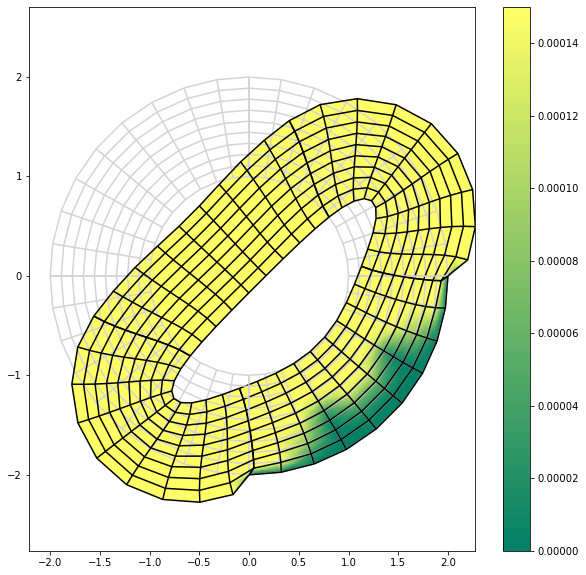

In [143]:
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)


In [96]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]
#print(dd)

#initial value
u= np.zeros(dd)
#print(u)


### first iteration ###
A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

u_d= solvers.make_solver(LS.A).dot(LS.b)

u_d = LS.complete(u_d)
#print(u_d)

x1= J(u)
print(x1)
#x2= grad_J(u)
#print(x2)
alpha= Wolfe_LineSearch(J, grad_J, u, u_d)
print('alpha=', alpha)

u += alpha*u_d
print(u)


solution = [LS.restrict(u)]
#print(solution[-1])

# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))

residual =  0.0003590464092893082
0.0
alpha= 1
[ 0.13659506  0.13665481  0.13689992 ... -0.43936726 -0.41710794
 -0.40360778]


2
residual =  0.0006322917797113021
phi_hat= 0.0011767918814022708
cond1:  -0.001445157994908669
alpha too big
delta= 1
alpha_int= 0.1
phi_hat= -0.0014096826365667873
cond1:  -0.0014480627112023038
alpha too big
delta= 0.1
alpha_int= 0.010000000000000002
phi_hat= -0.0014449111074527217
cond1:  -0.0014483531828316674
alpha too big
delta= 0.010000000000000002
alpha_int= 0.0010000000000000002
alpha= 0.0010000000000000002
3
residual =  0.0006316601190010711
phi_hat= 0.0005178958817634259
cond1:  -0.0014447891815982437
alpha too big
delta= 1
alpha_int= 0.1
phi_hat= -0.0014082525439444316
cond1:  -0.0014477162838526076
alpha too big
delta= 0.1
alpha_int= 0.010000000000000002
phi_hat= -0.0014444062791610836
cond1:  -0.0014480089940780438
alpha too big
delta= 0.010000000000000002
alpha_int= 0.0010000000000000002
alpha= 0.0010000000000000002
4
residual =  0.0006310289880973978
phi_hat= 0.00016512040648342433
cond1:  -0.001444435401023703
alpha too big
delta= 1
alpha_int= 0.1
phi_hat= -0.0014073

cond1:  -0.001441127563071208
alpha too big
delta= 0.1
alpha_int= 0.010000000000000002
phi_hat= -0.0014378544691529523
cond1:  -0.0014413518031826803
alpha too big
delta= 0.010000000000000002
alpha_int= 0.0010000000000000002
alpha= 0.0010000000000000002
22
residual =  0.0006197737349427843
phi_hat= -0.0007862412169259199
cond1:  -0.0014385819668646172
alpha too big
delta= 1
alpha_int= 0.1
phi_hat= -0.0014046842388412977
cond1:  -0.0014407815732349685
alpha too big
delta= 0.1
alpha_int= 0.010000000000000002
phi_hat= -0.0014375376352503194
cond1:  -0.0014410015338720038
alpha too big
delta= 0.010000000000000002
alpha_int= 0.0010000000000000002
alpha= 0.0010000000000000002
23
residual =  0.000619154426489063
phi_hat= -0.0007943023901166618
cond1:  -0.001438282332740903
alpha too big
delta= 1
alpha_int= 0.1
phi_hat= -0.0014047262709054337
cond1:  -0.0014404389623275482
alpha too big
delta= 0.1
alpha_int= 0.010000000000000002
phi_hat= -0.001437225657362437
cond1:  -0.0014406546252862128
alp

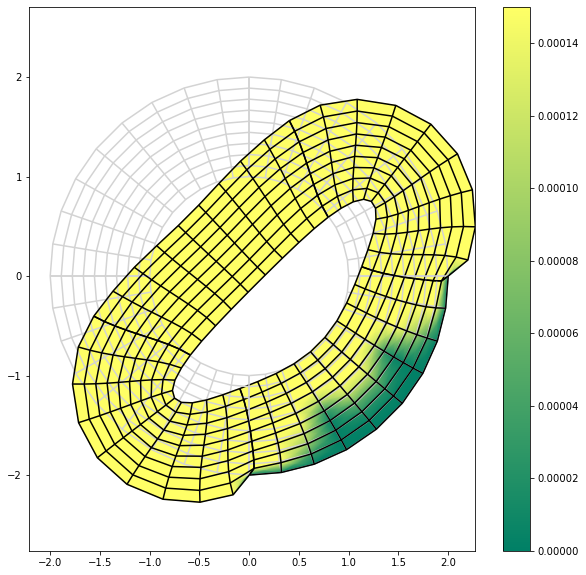

In [97]:
# solve linearized variational problem
epsilon= 1e-6
count= 1

stepsizes =[] 
ud_array = []

while True:
    count+=1
    print(count)
    # Assemble matrices and rhs in every iteration step
    A, b= ass_nonlinsystem(u)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    
    r= np.linalg.norm(LS.b) # compute residuum
    print('residual = ', r)

    u_d= solvers.make_solver(LS.A).dot(LS.b)

    u_d = LS.complete(u_d)

    alpha= Wolfe_LineSearch(J, grad_J, u, u_d)
    print('alpha=', alpha)

    u += alpha*u_d
    #print(u)
   
    ud_array.append(u_d)
    
    normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = abs(normed_du0-normed_du)
    #print('norm(delta_u) = ', normed_du)
    #print ('step size u_d = ', stepsize_du)
    
    stepsizes.append(stepsize_du)
    
    if r < epsilon:
        break
    elif count == 30:
        break
        
    normed_du0 = normed_du

# print deformation plot
get_defplot(u, patches_u, kvs_u)
#print(u)

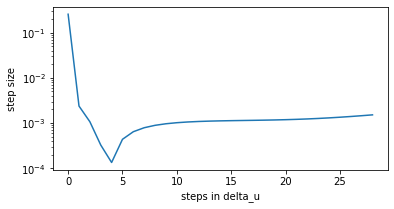

In [98]:
# plot history of step sizes
figsize(6,3)
yscale('log')
plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [ ]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    mu_1 = 0.01
    sigma = 0.9
    tau1= 0.3
    tau2 = 0.9
    gsi1= 1
    gsi2=10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha= 1
    phi_min = 1.e-6
    
    while True:
        if alpha > 1: # alpha to big
            aplha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            phi_hat= phi(alpha)
            if phi_hat < phi_min:
                return alpha 
            if phi_hat > phi(0) + mu1*alpha*derphi(0):
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
            
            else: # alpha to small & not to big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # to small
                    if alphainf: # true
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else:
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha
                    break
    
                
                
                        
                                
                        
            
            
    

    
    

In [22]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from itertools import product
from warnings import warn
from sklearn.datasets import make_spd_matrix
from matplotlib import ticker, cm

def WolfeLineSearch(f, f_grad, xk, pk, c1=1e-4, c2=0.9, amax=None, maxiter=10):
    """
    Find alpha that satisfies strong Wolfe conditions.
    Parameters
    ----------
    f : callable f(x)
        Objective function.
    f_grad : callable f'(x)
        Objective function gradient.
    xk : ndarray
        Starting point.
    pk : ndarray
        Search direction.
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size
    maxiter : int, optional
        Maximum number of iterations to perform.
    Returns
    -------
    alpha : float or None
        Alpha for which ``x_new = x0 + alpha * pk``,
        or None if the line search algorithm did not converge.
    phi : float or None
        New function value ``f(x_new)=f(x0+alpha*pk)``,
        or None if the line search algorithm did not converge.
    """

    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)

    alpha_star, phi_star, derphi_star = WolfeLineSearch2(phi, derphi, c1, c2, amax, maxiter)

    if derphi_star is None:
        warn('The line search algorithm did not converge', RuntimeWarning)

    return alpha_star, phi_star


def WolfeLineSearch2(phi, derphi, c1=1e-4, c2=0.9, amax=None, maxiter=10):
    """
    Find alpha that satisfies strong Wolfe conditions.
    alpha > 0 is assumed to be a descent direction.
    Parameters
    ----------
    phi : callable phi(alpha)
        Objective scalar function.
    derphi : callable phi'(alpha)
        Objective function derivative. Returns a scalar.
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size.
    maxiter : int, optional
        Maximum number of iterations to perform.
    Returns
    -------
    alpha_star : float or None
        Best alpha, or None if the line search algorithm did not converge.
    phi_star : float
        phi at alpha_star.
    derphi_star : float or None
        derphi at alpha_star, or None if the line search algorithm
        did not converge.
    """

    phi0 = phi(0.)
    derphi0 = derphi(0.)

    alpha0 = 0
    alpha1 = 1.0

    if amax is not None:
        alpha1 = min(alpha1, amax)

    phi_a1 = phi(alpha1)
    # derphi_a1 = derphi(alpha1) evaluated below

    phi_a0 = phi0
    derphi_a0 = derphi0

    #for i in range(maxiter):
    while True:
        if alpha1 == 0 or (amax is not None and alpha0 == amax):
            # alpha1 == 0: This shouldn't happen. Perhaps the increment has
            # slipped below machine precision?
            alpha_star = None
            phi_star = phi0
            derphi_star = None

            if alpha1 == 0:
                msg = 'Rounding errors prevent the line search from converging'
            else:
                msg = "The line search algorithm could not find a solution " + \
                      "less than or equal to amax: %s" % amax

            warn(msg, RuntimeWarning)
            break

        if (phi_a1 > phi0 + c1 * alpha1 * derphi0) or \
                ((phi_a1 >= phi_a0) and (i > 1)):
            alpha_star, phi_star, derphi_star = \
                _zoom(alpha0, alpha1, phi_a0,
                      phi_a1, derphi_a0, phi, derphi,
                      phi0, derphi0, c1, c2)
            break

        derphi_a1 = derphi(alpha1)
        if (abs(derphi_a1) <= -c2 * derphi0):
            alpha_star = alpha1
            phi_star = phi_a1
            derphi_star = derphi_a1
            break

        if (derphi_a1 >= 0):
            alpha_star, phi_star, derphi_star = \
                _zoom(alpha1, alpha0, phi_a1,
                      phi_a0, derphi_a1, phi, derphi,
                      phi0, derphi0, c1, c2)
            break

        alpha2 = 2 * alpha1  # increase by factor of two on each iteration
        if amax is not None:
            alpha2 = min(alpha2, amax)
        alpha0 = alpha1
        alpha1 = alpha2
        phi_a0 = phi_a1
        phi_a1 = phi(alpha1)
        derphi_a0 = derphi_a1

    else:
        # stopping test maxiter reached
        alpha_star = alpha1
        phi_star = phi_a1
        derphi_star = None
        warn('The line search algorithm did not converge', RuntimeWarning)

    return alpha_star, phi_star, derphi_star


def _cubicmin(a, fa, fpa, b, fb, c, fc):
    """
    Finds the minimizer for a cubic polynomial that goes through the
    points (a,fa), (b,fb), and (c,fc) with derivative at a of fpa.
    If no minimizer can be found, return None.
    """
    # f(x) = A *(x-a)^3 + B*(x-a)^2 + C*(x-a) + D
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            C = fpa
            db = b - a
            dc = c - a
            denom = (db * dc) ** 2 * (db - dc)
            d1 = np.empty((2, 2))
            d1[0, 0] = dc ** 2
            d1[0, 1] = -db ** 2
            d1[1, 0] = -dc ** 3
            d1[1, 1] = db ** 3
            [A, B] = np.dot(d1, np.asarray([fb - fa - C * db,
                                            fc - fa - C * dc]).flatten())
            A /= denom
            B /= denom
            radical = B * B - 3 * A * C
            xmin = a + (-B + np.sqrt(radical)) / (3 * A)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin


def _quadmin(a, fa, fpa, b, fb):
    """
    Finds the minimizer for a quadratic polynomial that goes through
    the points (a,fa), (b,fb) with derivative at a of fpa.
    """
    # f(x) = B*(x-a)^2 + C*(x-a) + D
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            D = fa
            C = fpa
            db = b - a * 1.0
            B = (fb - D - C * db) / (db * db)
            xmin = a - C / (2.0 * B)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin


def _zoom(a_lo, a_hi, phi_lo, phi_hi, derphi_lo,
          phi, derphi, phi0, derphi0, c1, c2):
    """
    Zoom stage of approximate linesearch satisfying strong Wolfe conditions.
    """

    maxiter = 10
    i = 0
    delta1 = 0.2  # cubic interpolant check
    delta2 = 0.1  # quadratic interpolant check
    phi_rec = phi0
    a_rec = 0
    while True:
        # interpolate to find a trial step length between a_lo and
        # a_hi Need to choose interpolation here. Use cubic
        # interpolation and then if the result is within delta *
        # dalpha or outside of the interval bounded by a_lo or a_hi
        # then use quadratic interpolation, if the result is still too
        # close, then use bisection

        dalpha = a_hi - a_lo
        if dalpha < 0:
            a, b = a_hi, a_lo
        else:
            a, b = a_lo, a_hi

        # minimizer of cubic interpolant
        # (uses phi_lo, derphi_lo, phi_hi, and the most recent value of phi)
        #
        # if the result is too close to the end points (or out of the
        # interval), then use quadratic interpolation with phi_lo,
        # derphi_lo and phi_hi if the result is still too close to the
        # end points (or out of the interval) then use bisection

        if (i > 0):
            cchk = delta1 * dalpha
            a_j = _cubicmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi,
                            a_rec, phi_rec)
        if (i == 0) or (a_j is None) or (a_j > b - cchk) or (a_j < a + cchk):
            qchk = delta2 * dalpha
            a_j = _quadmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi)
            if (a_j is None) or (a_j > b- qchk) or (a_j < a + qchk):
                a_j = a_lo + 0.5 * dalpha

        # Check new value of a_j

        phi_aj = phi(a_j)
        if (phi_aj > phi0 + c1 * a_j * derphi0) or (phi_aj >= phi_lo):
            phi_rec = phi_hi
            a_rec = a_hi
            a_hi = a_j
            phi_hi = phi_aj
        else:
            derphi_aj = derphi(a_j)
            if abs(derphi_aj) <= -c2 * derphi0:
                a_star = a_j
                val_star = phi_aj
                valprime_star = derphi_aj
                break
            if derphi_aj * (a_hi - a_lo) >= 0:
                phi_rec = phi_hi
                a_rec = a_hi
                a_hi = a_lo
                phi_hi = phi_lo
            else:
                phi_rec = phi_lo
                a_rec = a_lo
            a_lo = a_j
            phi_lo = phi_aj
            derphi_lo = derphi_aj
        i += 1
        if (i > maxiter):
            # Failed to find a conforming step size
            a_star = None
            val_star = None
            valprime_star = None
            break
    return a_star, val_star, valprime_star


In [23]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]
#print(dd)

#initial value
u= np.zeros(dd)
#print(u)


### first iteration ###
A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

u_d= solvers.make_solver(LS.A).dot(LS.b)

u_d = LS.complete(u_d)


x1= J(u)
print(x1)
#x2= grad_J(u)
#print(x2)
alpha= WolfeLineSearch(J, grad_J, u, u_d)
print('alpha=', alpha)

u += alpha[0]*u_d
print(u)


solution = [LS.restrict(u)]
#print(solution[-1])

# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))

residual =  0.0003590464092893082
0.0
alpha= (1.0, -0.0014483854574571522)
[ 0.13659506  0.13665481  0.13689992 ... -0.43936726 -0.41710794
 -0.40360778]


In [24]:
A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

u_d= solvers.make_solver(LS.A).dot(LS.b)

u_d = LS.complete(u_d)


x1= J(u)
print(x1)
#x2= grad_J(u)
#print(x2)
alpha= WolfeLineSearch(J, grad_J, u, u_d)
print('alpha=', alpha)

u += alpha[0]*u_d
print(u)


solution = [LS.restrict(u)]
#print(solution[-1])

# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))

residual =  0.0006322917797113021
-0.0014483854574571522


C:\Users\MHeig\AppData\Local\Temp\ipykernel_9712\3104850183.py:50: RuntimeWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', RuntimeWarning)


alpha= (None, None)


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'